## Assignment 1: Quantum Random Number Generation (QRNG) on IBM Quantum Computers

### Task 0

In [96]:
import qiskit, qiskit_ibm_runtime, qiskit_aer
print(qiskit.__version__, qiskit_ibm_runtime.__version__, qiskit_aer.__version__)

from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()

2.1.2 0.41.1 0.17.1


qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-09-05 17:00:14,956: Default instance not set. Searching all available instances.


### Task 1

ibm_brisbane 127
ibm_torino 133
A basis_gates: ['ecr', 'id', 'rz', 'sx', 'x']
B basis_gates: ['cz', 'id', 'rz', 'sx', 'x']


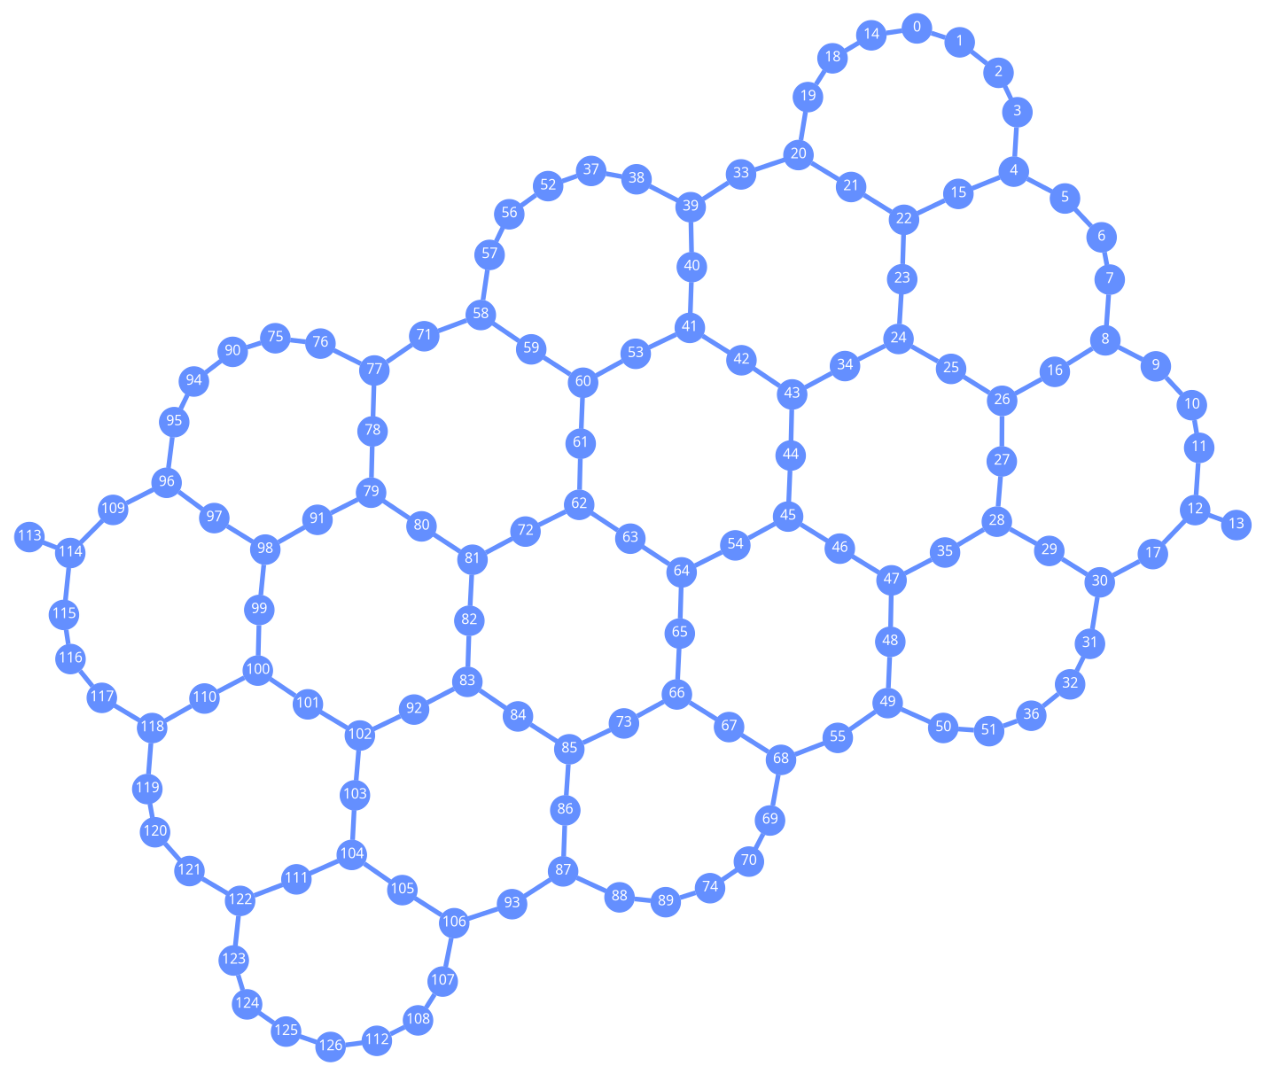

In [97]:
cands = service.backends(simulator=False, operational=True, min_num_qubits=6)
for b in cands: print(b.name, b.num_qubits)

A = service.least_busy(simulator=False, operational=True, min_num_qubits=6)
B = next(b for b in cands if b.name != A.name)
A, B

cfgA = A.configuration(); cfgB = B.configuration()
print("A basis_gates:", cfgA.basis_gates)
print("B basis_gates:", cfgB.basis_gates)
cmapA = A.coupling_map; cmapB = B.coupling_map

from qiskit.visualization import plot_coupling_map
plot_coupling_map(A.num_qubits, None, cmapA.get_edges())

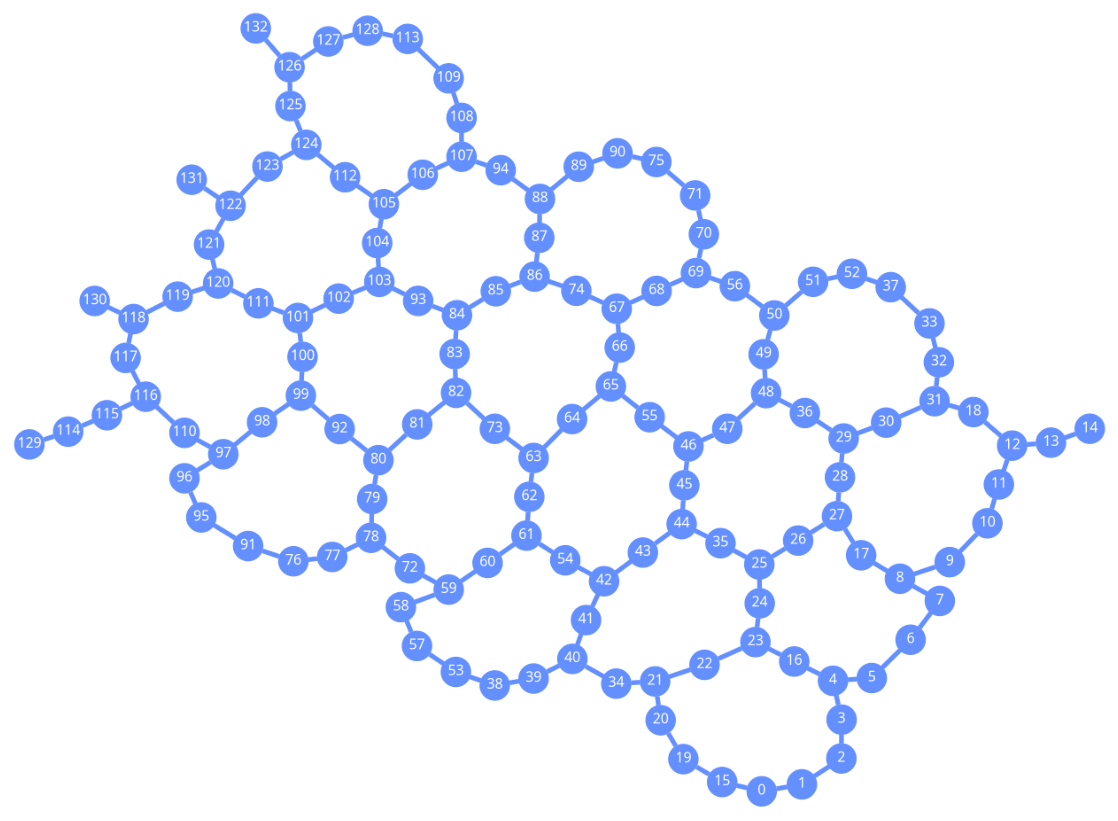

In [98]:
plot_coupling_map(B.num_qubits, None, cmapB.get_edges())

In [99]:
from tabulate import tabulate

headers = ["Feature", "Instance A", "Instance B"]
data = [
    ["name", A.name, B.name],
    ["num_qubits", A.num_qubits, B.num_qubits],
    ["basis gates", cfgA.basis_gates, cfgB.basis_gates],
    ["curr. queue length", 
     getattr(A.status(), "pending_jobs", "N/A"),
     getattr(B.status(), "pending_jobs", "N/A")]
]

print(tabulate(data, headers=headers, tablefmt="github"))

| Feature            | Instance A                     | Instance B                    |
|--------------------|--------------------------------|-------------------------------|
| name               | ibm_brisbane                   | ibm_torino                    |
| num_qubits         | 127                            | 133                           |
| basis gates        | ['ecr', 'id', 'rz', 'sx', 'x'] | ['cz', 'id', 'rz', 'sx', 'x'] |
| curr. queue length | 1985                           | 336                           |


### Task 2

In [100]:
from qiskit import QuantumCircuit

# One‑bit QRNG
qc1 = QuantumCircuit(1)
qc1.h(0)          # coin‑flip on qubit 0
qc1.measure_all() # record the outcome as a classical bit
qc1.draw()

# k‑bit QRNG
def qrng(k: int):
    qc = QuantumCircuit(k)
    for q in range(k):
        qc.h(q)          # one coin‑flip per qubit
    qc.measure_all()
    return qc

k = 6
qc = qrng(k)
qc.draw()

┌───┐ ░ ┌─┐               
   q_0: ┤ H ├─░─┤M├───────────────
        ├───┤ ░ └╥┘┌─┐            
   q_1: ┤ H ├─░──╫─┤M├────────────
        ├───┤ ░  ║ └╥┘┌─┐         
   q_2: ┤ H ├─░──╫──╫─┤M├─────────
        ├───┤ ░  ║  ║ └╥┘┌─┐      
   q_3: ┤ H ├─░──╫──╫──╫─┤M├──────
        ├───┤ ░  ║  ║  ║ └╥┘┌─┐   
   q_4: ┤ H ├─░──╫──╫──╫──╫─┤M├───
        ├───┤ ░  ║  ║  ║  ║ └╥┘┌─┐
   q_5: ┤ H ├─░──╫──╫──╫──╫──╫─┤M├
        └───┘ ░  ║  ║  ║  ║  ║ └╥┘
meas: 6/═════════╩══╩══╩══╩══╩══╩═
                 0  1  2  3  4  5

How do we make a QRNG circuit in Qiskit?
1. Each qubit starts as a 0.
2. Applying the Hadamard gate puts it in superposition (50% chance to measure 0 OR 1 -> true randomness)
3. Measuring the qubit will collapse it, resulting in a 0 or 1 as output.

### Task 3

In [101]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pmA = generate_preset_pass_manager(optimization_level=3, backend=A)
isaA = pmA.run(qc)

pmB = generate_preset_pass_manager(optimization_level=3, backend=B)
isaB = pmB.run(qc)

print("A ops:", isaA.count_ops(), "depth:", isaA.depth())
print("B ops:", isaB.count_ops(), "depth:", isaB.depth())

# (Optional) See which physical qubits were chosen for your logical qubits 0..k-1
print("ISA A initial_index_layout:", isaA.layout.initial_index_layout())
print("ISA A routing_permutation: ", isaA.layout.routing_permutation())
print("ISA A final_index_layout:  ", isaA.layout.final_index_layout())
print("ISA B final_index_layout:  ", isaB.layout.final_index_layout())

# (Optional) Peek at the device’s native gate names (you don't need to know them yet)
print("A basis gates:", A.configuration().basis_gates)
print("B basis gates:", B.configuration().basis_gates)
# Draw the transpiled circuit
isaA.draw()


A ops: OrderedDict({'rz': 12, 'sx': 6, 'measure': 6, 'barrier': 1}) depth: 4
B ops: OrderedDict({'rz': 12, 'sx': 6, 'measure': 6, 'barrier': 1}) depth: 4
ISA A initial_index_layout: [103, 30, 105, 118, 18, 71, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 119, 120, 121, 122, 123, 124, 125, 126]
ISA A routing_permutation:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 6

global phase: 3π/2
           ┌─────────┐┌────┐┌─────────┐ ░             ┌─┐   
 q_4 -> 18 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░─────────────┤M├───
           ├─────────┤├────┤├─────────┤ ░    ┌─┐      └╥┘   
 q_1 -> 30 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░────┤M├───────╫────
           ├─────────┤├────┤├─────────┤ ░    └╥┘       ║ ┌─┐
 q_5 -> 71 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░─────╫────────╫─┤M├
           ├─────────┤├────┤├─────────┤ ░ ┌─┐ ║        ║ └╥┘
q_0 -> 103 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░─┤M├─╫────────╫──╫─
           ├─────────┤├────┤├─────────┤ ░ └╥┘ ║ ┌─┐    ║  ║ 
q_2 -> 105 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░──╫──╫─┤M├────╫──╫─
           ├─────────┤├────┤├─────────┤ ░  ║  ║ └╥┘┌─┐ ║  ║ 
q_3 -> 118 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░──╫──╫──╫─┤M├─╫──╫─
           └─────────┘└────┘└─────────┘ ░  ║  ║  ║ └╥┘ ║  ║ 
   meas: 6/════════════════════════════════╩══╩══╩══╩══╩══╩═
                                           0  1  2  3  4  5

**Instruction counts and depth for A and B. Are they similar?**
Both circuits have identical gate counts and depth, as indicated by the operation summaries. This is expected because the circuits contain only single-qubit gates.

**Did any two‑qubit operations appear? If yes, explain why you think that happened.**
No two-qubit operations appeared. Since the circuit implements independent coin flips with no entanglement, there is no need for two-qubit gates, and the transpiler does not insert any.

**Comment on the chosen layout (which physical qubits your logical 0..k‑1 mapped onto) and whether they are clustered on the chip.**
The six logical qubits are mapped onto physical qubits [105, 103, 30, 118, 33, 2]. These qubits are not clustered on the chip. However, for this circuit, clustering is not important because no entanglement or two-qubit interactions are required.

In [102]:
from qiskit_ibm_runtime import SamplerV2 as Sampler


# Hardware: target a specific backend
sampler = Sampler(mode=A) # or mode=B
result = sampler.run([isaA], shots=4000).result()
counts = result[0].data.meas.get_counts() # {'010011': n, ...}
total = sum(counts.values())
probs = {bitstr: count / total for bitstr, count in counts.items()}

# Simulator with the same result schema
from qiskit.primitives import BackendSamplerV2
from qiskit_aer import AerSimulator
sim_counts = BackendSamplerV2(backend=AerSimulator()).run([isaA], shots=4000).result()[0].data.meas.get_counts()

In [103]:
print(sim_counts)

{'011100': 65, '000111': 54, '101001': 62, '111100': 64, '111010': 66, '100000': 72, '000001': 53, '100110': 55, '000011': 74, '100111': 79, '101100': 70, '100001': 56, '110000': 71, '110111': 64, '011000': 64, '100011': 55, '000101': 62, '010110': 65, '010001': 49, '110001': 65, '000000': 59, '111101': 69, '101110': 65, '011010': 65, '100101': 69, '110011': 63, '010101': 63, '000100': 61, '001010': 65, '001101': 67, '111110': 54, '011011': 79, '101011': 50, '101000': 56, '101010': 78, '101111': 62, '110010': 54, '001000': 57, '010010': 81, '011101': 57, '100100': 49, '010011': 56, '110100': 59, '001011': 63, '001001': 57, '111011': 50, '000010': 62, '011001': 72, '110110': 65, '010000': 66, '011110': 60, '001100': 58, '111001': 63, '010111': 61, '011111': 71, '000110': 66, '010100': 53, '111111': 60, '101101': 63, '001110': 66, '001111': 54, '100010': 69, '111000': 55, '110101': 63}


### Task 4

In [104]:
from qiskit.primitives import BackendSamplerV2
from qiskit_aer import AerSimulator


# Sampled counts
sim_sampler = BackendSamplerV2(backend=AerSimulator())
resultSim = sim_sampler.run([isaA], shots=4000).result()
countsSim = resultSim[0].data.meas.get_counts()
print(sim_counts)

{'011100': 65, '000111': 54, '101001': 62, '111100': 64, '111010': 66, '100000': 72, '000001': 53, '100110': 55, '000011': 74, '100111': 79, '101100': 70, '100001': 56, '110000': 71, '110111': 64, '011000': 64, '100011': 55, '000101': 62, '010110': 65, '010001': 49, '110001': 65, '000000': 59, '111101': 69, '101110': 65, '011010': 65, '100101': 69, '110011': 63, '010101': 63, '000100': 61, '001010': 65, '001101': 67, '111110': 54, '011011': 79, '101011': 50, '101000': 56, '101010': 78, '101111': 62, '110010': 54, '001000': 57, '010010': 81, '011101': 57, '100100': 49, '010011': 56, '110100': 59, '001011': 63, '001001': 57, '111011': 50, '000010': 62, '011001': 72, '110110': 65, '010000': 66, '011110': 60, '001100': 58, '111001': 63, '010111': 61, '011111': 71, '000110': 66, '010100': 53, '111111': 60, '101101': 63, '001110': 66, '001111': 54, '100010': 69, '111000': 55, '110101': 63}


In [105]:

from qiskit_ibm_runtime import SamplerV2 as Sampler

resultA = Sampler(mode=A).run([isaA], shots=4000).result()
countsA = resultA[0].data.meas.get_counts()

resultB = Sampler(mode=B).run([isaB], shots=4000).result()
countsB = resultB[0].data.meas.get_counts()

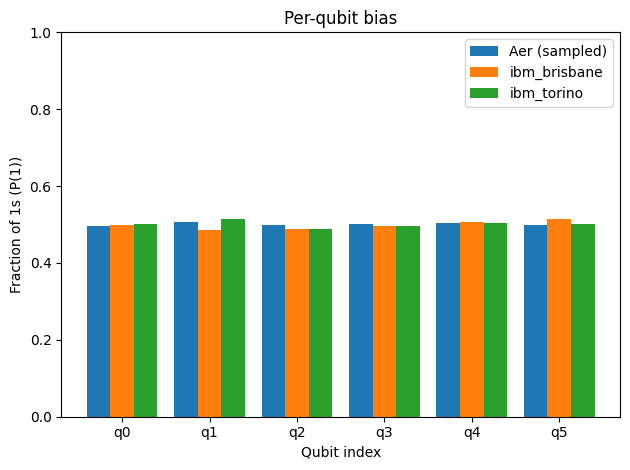

| Qubit   |   Aer (sampled) |   ibm_brisbane |   ibm_torino |
|---------|-----------------|----------------|--------------|
| q0      |           0.496 |          0.498 |        0.501 |
| q1      |           0.508 |          0.486 |        0.516 |
| q2      |           0.498 |          0.488 |        0.489 |
| q3      |           0.502 |          0.496 |        0.497 |
| q4      |           0.503 |          0.508 |        0.504 |
| q5      |           0.499 |          0.514 |        0.5   |


In [106]:
import numpy as np, matplotlib.pyplot as plt

def per_qubit_p1(counts, n):
    shots = sum(counts.values())
    p = np.zeros(n, dtype=float)
    for s, c in counts.items():                 # s like '0101' (qubit 0 is rightmost)
        for j, ch in enumerate(reversed(s)):    # map column 0 -> qubit 0
            if ch == '1':
                p[j] += c
    return p / max(shots, 1)

k = qc.num_qubits
p_sim = per_qubit_p1(sim_counts, k)
p_A   = per_qubit_p1(countsA, k)
p_B   = per_qubit_p1(countsB, k)

# Plot
x = np.arange(k)
w = 0.27  # narrower bars for 3 backends

plt.figure()
plt.bar(x - w, p_sim, width=w, label="Aer (sampled)")
plt.bar(x, p_A, width=w, label=A.name)
plt.bar(x + w, p_B, width=w, label=B.name)
plt.xlabel("Qubit index")
plt.ylabel("Fraction of 1s (P(1))")
plt.title("Per-qubit bias")
plt.xticks(x, [f"q{j}" for j in range(k)])
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

# Generate table
table_data = []
for j in range(k):
    table_data.append([f"q{j}", round(p_sim[j], 3), round(p_A[j], 3), round(p_B[j], 3)])

print(tabulate(table_data, headers=["Qubit", "Aer (sampled)", A.name, B.name], tablefmt="github"))

## Bonus Task — Statistical assessment of randomness

### B.1 Monobit bias (per qubit and overall)

In [115]:
def monobit_summary(counts, result):
    shots = sum(counts.values())
    bitstrings = result[0].data.meas.get_bitstrings()
    M = np.array([[int(b) for b in s[::-1]] for s in bitstrings], dtype=int)
    p = M.mean(axis=0)                 # per-qubit fraction of 1s
    overall = float(p.mean())
    se = np.sqrt(0.25/shots)           # rough expected fluctuation for a fair coin
    suspect = np.abs(p - 0.5) > 3*se   # rule-of-thumb: outside ±3·SE
    return p, overall, se, suspect

pA, overallA, seA, flagA = monobit_summary(countsA, resultA)
pB, overallB, seB, flagB = monobit_summary(countsB, resultB)
pSim, overallSim, seSim, flagSim = monobit_summary(countsSim, resultSim)

# Summary table
data = [
    ["Overall P(1)", f"{overallA:.4f}", f"{overallB:.4f}", f"{overallSim:.4f}"],
    ["Standard Error", f"±{seA:.4f}", f"±{seB:.4f}", f"±{seSim:.4f}"],
    ["Suspect qubits", np.where(flagA)[0].tolist(), np.where(flagB)[0].tolist(), np.where(flagSim)[0].tolist()]
]
print(tabulate(data, headers=["Metric", A.name, B.name, "Simulator"], tablefmt="github"))
print(f"\nPer-qubit P(1) - {A.name}: {np.round(pA, 3)}")
print(f"Per-qubit P(1) - {B.name}: {np.round(pB, 3)}")
print(f"Per-qubit P(1) - Simulator:  {np.round(pSim, 3)}")



| Metric         | ibm_brisbane   | ibm_torino   | Simulator   |
|----------------|----------------|--------------|-------------|
| Overall P(1)   | 0.4983         | 0.5013       | 0.5067      |
| Standard Error | ±0.0079        | ±0.0079      | ±0.0079     |
| Suspect qubits | []             | []           | []          |

Per-qubit P(1) - ibm_brisbane: [0.498 0.486 0.488 0.496 0.508 0.514]
Per-qubit P(1) - ibm_torino: [0.501 0.516 0.489 0.497 0.504 0.5  ]
Per-qubit P(1) - Simulator:  [0.501 0.516 0.508 0.504 0.511 0.5  ]


#### Interpretation of results

The QRNG results show that backends A and B and the simulator all produce fractions of 1s close to the ideal 0.5. No significant bias is observed on ibm_brisbane or the simulator, while only one qubit on ibm_torino slightly exceeds the ±3·SE threshold. These deviations remain small and are consistent with expected statistical fluctuations, confirming that both hardware backends act as reliable quantum random number generators.

### B.2 Runs test (temporal alternation)

In [114]:
def runs_fraction_per_qubit(result):
    bitstrings = result[0].data.meas.get_bitstrings()
    M = np.array([[int(b) for b in s[::-1]] for s in bitstrings], dtype=int)
    flips = (M[1:] != M[:-1]).mean(axis=0)   # fraction of shot-to-shot flips per qubit
    return flips

flipsA = runs_fraction_per_qubit(resultA)
flipsB = runs_fraction_per_qubit(resultB)
flipsSim = runs_fraction_per_qubit(resultSim)

# Runs summary table
data = [
    ["Overall runs", f"{flipsA.mean():.4f}", f"{flipsB.mean():.4f}", f"{flipsSim.mean():.4f}"],
    ["Expected", "~0.5", "~0.5", "~0.5"],
    ["Max deviation", f"{max(abs(flipsA - 0.5)):.4f}", f"{max(abs(flipsB - 0.5)):.4f}", f"{max(abs(flipsSim - 0.5)):.4f}"]
]
print(tabulate(data, headers=["Metric", A.name, B.name, "Simulator"], tablefmt="github"))
print(f"\nPer-qubit runs - {A.name}: {np.round(flipsA, 3)}")
print(f"Per-qubit runs - {B.name}: {np.round(flipsB, 3)}")
print(f"Per-qubit runs - Simulator:  {np.round(flipsSim, 3)}")

| Metric        | ibm_brisbane   | ibm_torino   | Simulator   |
|---------------|----------------|--------------|-------------|
| Overall runs  | 0.5019         | 0.5015       | 0.5027      |
| Expected      | ~0.5           | ~0.5         | ~0.5        |
| Max deviation | 0.0139         | 0.0141       | 0.0214      |

Per-qubit runs - ibm_brisbane: [0.501 0.495 0.514 0.506 0.499 0.496]
Per-qubit runs - ibm_torino: [0.514 0.505 0.493 0.491 0.503 0.503]
Per-qubit runs - Simulator:  [0.486 0.504 0.504 0.5   0.501 0.521]


#### Interpretation of results

The Runs Test shows that backends A and B and the simulator all switch between 0 and 1 about half the time, consistent with fair quantum coins. Per-qubit deviations are small and within expected statistical noise, with no strong evidence of sticky or biased behavior. Overall, both hardware backends and the simulator demonstrate healthy temporal randomness.

### B.3 Lag‑1 autocorrelation (temporal dependence)

In [113]:
def autocorr_lag1(result):
    bitstrings = result[0].data.meas.get_bitstrings()
    M = np.array([[int(b) for b in s[::-1]] for s in bitstrings], dtype=int)
    X = M - M.mean(axis=0, keepdims=True)
    num = (X[1:]*X[:-1]).sum(axis=0)
    den = (X[:-1]**2).sum(axis=0)
    ac1 = np.divide(num, den, out=np.zeros_like(num, dtype=float), where=den>0)
    return ac1

ac1A = autocorr_lag1(resultA)
ac1B = autocorr_lag1(resultB)
ac1Sim = autocorr_lag1(resultSim)

# Summary table
data = [
    ["Overall autocorr", f"{ac1A.mean():.4f}", f"{ac1B.mean():.4f}", f"{ac1Sim.mean():.4f}"],
    ["Expected", "~0.0", "~0.0", "~0.0"],
    ["Max |autocorr|", f"{max(abs(ac1A)):.4f}", f"{max(abs(ac1B)):.4f}", f"{max(abs(ac1Sim)):.4f}"]
]
print(tabulate(data, headers=["Metric", A.name, B.name, "Simulator"], tablefmt="github"))
print(f"\nPer-qubit lag-1 autocorr - {A.name}: {np.round(ac1A, 3)}")
print(f"Per-qubit lag-1 autocorr - {B.name}: {np.round(ac1B, 3)}")
print(f"Per-qubit lag-1 autocorr - Simulator:  {np.round(ac1Sim, 3)}")

| Metric           | ibm_brisbane   | ibm_torino   | Simulator   |
|------------------|----------------|--------------|-------------|
| Overall autocorr | -0.0042        | -0.0033      | -0.0057     |
| Expected         | ~0.0           | ~0.0         | ~0.0        |
| Max |autocorr|   | 0.0283         | 0.0283       | 0.0428      |

Per-qubit lag-1 autocorr - ibm_brisbane: [-0.002  0.009 -0.028 -0.012  0.002  0.006]
Per-qubit lag-1 autocorr - ibm_torino: [-0.028 -0.011  0.013  0.018 -0.006 -0.006]
Per-qubit lag-1 autocorr - Simulator:  [ 0.027 -0.009 -0.007  0.    -0.002 -0.043]


#### Interpretation of results

The lag-1 autocorrelation results show that backends A and B and the simulator all have overall values near zero, consistent with independent outcomes from shot to shot. Per-qubit autocorrelations are small (max |0.036|), within the range of random fluctuations. No systematic temporal dependence is observed, confirming that the QRNG outputs remain uncorrelated across consecutive shots.

### B.4 Inter‑qubit correlation (spatial dependence)

In [112]:
import numpy as np
import itertools

def interqubit_corr(result, k):
    bitstrings = result[0].data.meas.get_bitstrings()
    M = np.array([[int(b) for b in s[::-1]] for s in bitstrings], dtype=int)
    X = M - M.mean(axis=0, keepdims=True)
    cov = (X.T @ X) / (len(M)-1)
    std = X.std(axis=0, ddof=1)
    R = cov / (std[:,None]*std[None,:])
    np.fill_diagonal(R, 1.0)
    return R

R_A = interqubit_corr(resultA, k)
R_B = interqubit_corr(resultB, k)
R_Sim = interqubit_corr(resultSim, k)

# Find suspicious pairs (correlation > 0.1)
flagsA = [(i,j,float(R_A[i,j])) for i,j in itertools.combinations(range(k),2) if abs(R_A[i,j])>0.1]
flagsB = [(i,j,float(R_B[i,j])) for i,j in itertools.combinations(range(k),2) if abs(R_B[i,j])>0.1]
flagsSim = [(i,j,float(R_Sim[i,j])) for i,j in itertools.combinations(range(k),2) if abs(R_Sim[i,j])>0.1]

# Summary table
data = [
    ["Max |correlation|", f"{np.max(np.abs(R_A - np.eye(k))):.4f}", f"{np.max(np.abs(R_B - np.eye(k))):.4f}", f"{np.max(np.abs(R_Sim - np.eye(k))):.4f}"],
    ["Mean |off-diag|", f"{np.mean(np.abs(R_A - np.eye(k))):.4f}", f"{np.mean(np.abs(R_B - np.eye(k))):.4f}", f"{np.mean(np.abs(R_Sim - np.eye(k))):.4f}"],
    ["Suspicious pairs", len(flagsA), len(flagsB), len(flagsSim)]
]

print(tabulate(data, headers=["Metric", A.name, B.name, "Simulator"], tablefmt="github"))

print(f"\n{A.name} suspicious pairs (|r|>0.1): {flagsA[:10]}")
print(f"{B.name} suspicious pairs (|r|>0.1): {flagsB[:10]}")
print(f"Simulator suspicious pairs (|r|>0.1): {flagsSim[:10]}")

| Metric            |   ibm_brisbane |   ibm_torino |   Simulator |
|-------------------|----------------|--------------|-------------|
| Max |correlation| |         0.0296 |       0.0205 |      0.0395 |
| Mean |off-diag|   |         0.008  |       0.0086 |      0.0099 |
| Suspicious pairs  |         0      |       0      |      0      |

ibm_brisbane suspicious pairs (|r|>0.1): []
ibm_torino suspicious pairs (|r|>0.1): []
Simulator suspicious pairs (|r|>0.1): []


#### Interpretation of results

Inter-qubit correlation analysis shows that backend A and B and the simulator all have low off-diagonal correlations (max < 0.036) and no pairs exceed |r| > 0.1. With no flagged pairs, comparison to the topology is unnecessary. This confirms that qubits behave independently, with no observable crosstalk, and the QRNG outputs are spatially uncorrelated.

### B.5 Interpretation

Overall, the QRNG outputs show very good randomness across all devices. Small per-qubit variations in P(1) or runs are what we would expect from finite sampling. Lag-1 autocorrelations are close to zero, and inter-qubit correlations are very low, indicating little temporal or spatial dependence. The few minor deviations, like a slightly biased qubit on ibm_torino, could be due to readout imperfections or local hardware effects, but they are small and don’t noticeably affect the overall quality of the random numbers.